# Modeling & EDA

My first three notebooks were devoted to collecting text data from Reddit and creating a dataframe which I'll use to train my models. In this notebook, I'll subject my data to a variety of text preprocessing techniques and train a variety of classification models before exploring and interpreting my results.

### Import Modules

In [84]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
import pylab as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read in and clean data

In [5]:
df = pd.read_csv('data/joker_batman.csv')

In [6]:
df.head()

,Unnamed: 0,posts,label
0,0,Weekly Batman Comics (12/12/2018): The Batman ...,1
1,1,Weekly Batman Discussion Thread - Which crimin...,1
2,2,Wholesome,1
3,3,Hardy tells a story about Bale during TDKR´s f...,1
4,4,'Batman Villains' by Glen Orbik and Laurel Ble...,1


In [7]:
df.drop('Unnamed: 0', axis = 1, inplace=True)

In [8]:
df.head()

,posts,label
0,Weekly Batman Comics (12/12/2018): The Batman ...,1
1,Weekly Batman Discussion Thread - Which crimin...,1
2,Wholesome,1
3,Hardy tells a story about Bale during TDKR´s f...,1
4,'Batman Villains' by Glen Orbik and Laurel Ble...,1


In [9]:
df.shape

(4230, 2)

### Checking the distribution of my classes

In [10]:
df['label'].value_counts(normalize=False)

0    2150
1    2080
Name: label, dtype: int64

In [11]:
df['label'].value_counts(normalize=True)

0    0.508274
1    0.491726
Name: label, dtype: float64

Looks like my classes are pretty well balanced, so I am ready to split my data into training and testing sets.

### Train/Test Split

I need to split my data into a training set for building my models and a training set to see how well my models perform on new data.

In [12]:
X = df['posts']
y = df['label']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Modeling

In the cells below, I will instantiate a variety of NLP techniques and models. I will perform Gridsearch operations to determine the best parameters for tuning my models in order to optimize accuracy scores. Based on best test score, I'll perform EDA on the two best models. 

### Multinomial Naive Bayes & CountVectorizer

In [38]:
cv = CountVectorizer()
model = MultinomialNB()

In [39]:
pipe = Pipeline([
    ('cv', cv),
    ('model', model)
])

In [40]:
params = {
    'cv__stop_words': [None, 'english'],
    'cv__max_features': [3000, 4000],
    'cv__ngram_range': [(1,1), (1,2)],
    'model__alpha': [0.1, 2.0]
}
gs = GridSearchCV(pipe, param_grid=params, cv=5)
gs.fit(X_train, y_train);

In [41]:
gs.best_params_

{'cv__max_features': 3000,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': None,
 'model__alpha': 0.1}

In [42]:
gs.best_score_

0.8899747793190416

In [43]:
gs.score(X_test, y_test)

0.9158790170132325

### Multinomial Naive Bayes + TF-IDF

In [44]:
tfidf = TfidfVectorizer()

In [45]:
pipe = Pipeline([
    ('tfidf', tfidf),
    ('model', model)
])

In [46]:
params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__analyzer': ['word', 'char'],
    'tfidf__max_features': [None, 1000],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

In [47]:
gs = GridSearchCV(pipe, param_grid=params, cv=5)
gs.fit(X_train, y_train);

In [48]:
gs.best_params_

{'tfidf__analyzer': 'word',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [49]:
gs.best_score_

0.9117276166456494

In [50]:
gs.score(X_test, y_test)

0.9395085066162571

### Random Forest Classifier + CountVectorizer

In [98]:
rf = RandomForestClassifier()

In [105]:
pipe = Pipeline([
    ('cv', cv),
    ('rf', rf)
])

In [106]:
params = {
    'cv__stop_words': [None, 'english'],
    'cv__max_features': [3000, 4000],
    'cv__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [5, 10, 15],
    'rf__max_depth': [None, 7, 8, 6]
}

In [107]:
gs = GridSearchCV(pipe, param_grid=params, cv=5)
gs.fit(X_train, y_train);

In [108]:
gs.best_params_

{'cv__max_features': 3000,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english',
 'rf__max_depth': None,
 'rf__n_estimators': 15}

In [109]:
gs.best_score_

0.9397856242118537

In [110]:
gs.score(X_test, y_test)

0.947069943289225

In [111]:
predictions = gs.predict(X_test)
predictions

array([1, 0, 1, ..., 1, 0, 0])

In [112]:
cm = confusion_matrix(y_test, predictions)
cm

array([[510,  28],
       [ 28, 492]])

**Model Performance**

Correct Predictions
- True Positive: **516**
- True Negative: **487**

Incorrect Predictions
- False Positive: **22**
- False Negative: **33**

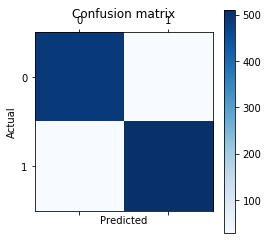

In [113]:
cm = confusion_matrix(y_test, predictions, labels=[1,0])
%matplotlib inline
plt.matshow(cm)
plt.set_cmap('Blues')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Accuracy**

In [114]:
(516+487)/(516+487+22+33)

0.9480151228733459

**Specificity**

In [115]:
487/(487+22)

0.9567779960707269

**Sensitivity**

In [116]:
516/(516+33)

0.9398907103825137

**Misclassification**

In [117]:
(33+22)/(516+487+22+33)

0.05198487712665406

In [118]:
X_text = cv.fit_transform(X_train)

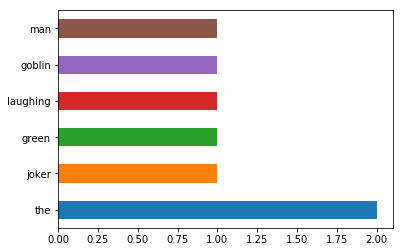

In [119]:
batman = pd.DataFrame(X_text.toarray(), columns=cv.get_feature_names())
batman.iloc[1].sort_values(0, ascending=False).head(6).plot(kind='barh')

### Random Forest Classifier + TF-IDF

In [61]:
pipe = Pipeline([
    ('tfidf', tfidf),
    ('rf', rf)
])

In [62]:
params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__analyzer': ['word', 'char'],
    'tfidf__max_features': [None, 1000],
    'tfidf__ngram_range': [(2,2), (1,2)],
    'rf__n_estimators': [5, 10, 15],
    'rf__max_depth': [None, 7, 8, 6]
}

In [64]:
gs = GridSearchCV(pipe, param_grid=params, cv=5)
gs.fit(X_train, y_train);

In [65]:
gs.best_params_

{'rf__max_depth': None,
 'rf__n_estimators': 15,
 'tfidf__analyzer': 'word',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': 'english'}

In [66]:
gs.best_score_

0.9385245901639344

In [67]:
gs.score(X_test, y_test)

0.9385633270321361

### Logistic Regression + CountVectorizer

In [68]:
lr = LogisticRegression()

In [69]:
pipe = Pipeline([
    ('cv', cv),
    ('lr', lr)
])

In [70]:
params = {
    'cv__stop_words': [None, 'english'],
    'cv__max_features': [3000, 4000],
    'cv__ngram_range': [(1,1), (1,2)],
    'lr__C': [12.0, 13.0]
}

In [71]:
gs = GridSearchCV(pipe, param_grid=params, cv=5)
gs.fit(X_train, y_train);

In [72]:
gs.best_params_

{'cv__max_features': 3000,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': None,
 'lr__C': 12.0}

In [73]:
gs.best_score_

0.932219419924338

In [74]:
gs.score(X_test, y_test)

0.946124763705104

### Logistic Regression + TF-IDF

In [75]:
pipe = Pipeline([
    ('tfidf', tfidf),
    ('lr', lr)
])

In [76]:
params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__analyzer': ['word', 'char'],
    'tfidf__max_features': [None, 1000],
    'tfidf__ngram_range': [(2,2), (1,2)],
    'lr__C': [10.0, 10.1]
}

In [77]:
gs = GridSearchCV(pipe, param_grid=params, cv=5)
gs.fit(X_train, y_train);

In [78]:
gs.best_params_

{'lr__C': 10.0,
 'tfidf__analyzer': 'word',
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [79]:
gs.best_score_

0.9394703656998739

In [80]:
gs.score(X_test, y_test)

0.9593572778827977

In [82]:
predictions = gs.predict(X_test)
predictions

array([1, 0, 1, ..., 1, 0, 0])

In [85]:
cm = confusion_matrix(y_test, predictions)
cm

array([[519,  19],
       [ 24, 496]])

**Model Performance**

Correct Predictions
- True Positive: **519**
- True Negative: **496**

Incorrect Predictions
- False Positive: **19**
- False Negative: **24**

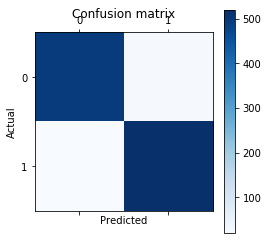

In [86]:
cm = confusion_matrix(y_test, predictions, labels=[1,0])
plt.matshow(cm)
plt.set_cmap('Blues')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Accuracy**

In [88]:
(519+496)/(519+496+19+24)

0.9593572778827977

**Specificity**

In [90]:
496/(496+19)

0.9631067961165048

**Sensitivity**

In [92]:
519/(519+24)

0.9558011049723757

**Misclassification**

In [94]:
(24+19)/(519+496+19+24)

0.04064272211720227

In [95]:
X_text = tfidf.fit_transform(X_train)

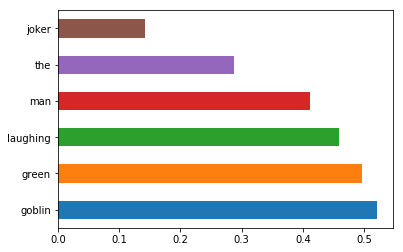

In [96]:
batman = pd.DataFrame(X_text.toarray(), columns=tfidf.get_feature_names())
batman.iloc[1].sort_values(0, ascending=False).head(6).plot(kind='barh')

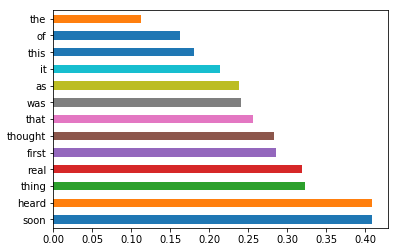

In [97]:
joker = pd.DataFrame(X_text.toarray(), columns=tfidf.get_feature_names())
joker.iloc[0].sort_values(0, ascending=False).head(13).plot(kind='barh')

### Conclusion

My best model is a logistic regression classifier; trained on data that was processed based on Text Frequency-Inverse Document Freqency; yielding an accuracy rate of 95.9%